In [43]:
import subprocess
from pathlib import Path
from tempfile import TemporaryDirectory

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim

from tqdm.notebook import tqdm
from IPython.display import Video, Image

# Features TODO
* Possible to turn a bunch of frames into a matplotlib slideshow?
* Output writers besides ffmpeg?

In [55]:
class Loom:
    def __init__(
        self,
        output_filepath: str | Path,
        frames_directory: str | Path = Path(TemporaryDirectory().name),
        fps: int = 30,
        keep_frames: bool = False,
        overwrite: bool = False,
        verbose: bool = False,
        savefig_kwargs: dict = {}
    ) -> None:
        self.output_filepath = Path(output_filepath)
        self.frames_directory = Path(frames_directory)
        self.fps = fps
        self.keep_frames = keep_frames
        self.overwrite = overwrite
        self.verbose = verbose
        self.savefig_kwargs = savefig_kwargs
        
        self.frame_filepaths = []
        self.frame_counter = 0
        self.file_format = self.output_filepath.suffix[1:]

        self.output_directory = self.output_filepath.parent
        self.output_directory.mkdir(parents=True, exist_ok=True)
        self.frames_directory.mkdir(parents=True, exist_ok=True)

        if self.verbose:
            print(f"output_filepath: {self.output_filepath}")
            print(f"frames_directory: {self.frames_directory}")
    
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        self.save_video()
        return
    
    def save_frame(self, fig):
        frame_filepath = self.frames_directory / f"frame_{self.frame_counter:06d}.png"

        self.frame_counter += 1
        self.frame_filepaths.append(frame_filepath)
        
        if self.verbose:
            print(f"Saving frame {self.frame_counter} to {frame_filepath}")
        
        fig.savefig(frame_filepath, **self.savefig_kwargs)
        plt.close(fig)

    def save_video(self):
        if self.file_format == "mp4":
            command = [
                "ffmpeg",
                "-y",
                "-framerate", str(self.fps),
                "-i", str(self.frames_directory / "frame_%06d.png"),
                "-c:v", "libx264", 
                "-pix_fmt", "yuv420p",
                str(self.output_filepath)
            ]
        elif self.file_format == "gif":
            command = [
                "ffmpeg",
                "-y",
                "-framerate", str(self.fps),
                "-f", "image2",
                "-i", str(self.frames_directory / "frame_%06d.png"),
                # https://superuser.com/a/556031
                "-vf", 'split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse',
                str(self.output_filepath)
            ]
        
        PIPE = subprocess.PIPE
        process = subprocess.Popen(command, stdin=PIPE, stdout=PIPE, stderr=PIPE)
        stdout, stderr = process.communicate()

        if self.verbose:
            print(" ".join(command))
            print(stdout.decode())
            print(stderr.decode())

        if not self.keep_frames:
            for frame_filename in self.frame_filepaths:
                if frame_filename.exists():
                    frame_filename.unlink()

    def show(self):
        if self.file_format in {"mp4", "mkv"}:
            return Video(str(self.output_filepath))
        elif self.file_format in {"gif", "apng"}:
            return Image(str(self.output_filepath))

output_filepath: sine_wave_animation.gif
frames_directory: /tmp/tmp_oppo57u


  0%|          | 0/100 [00:00<?, ?it/s]

Saving frame 1 to /tmp/tmp_oppo57u/frame_000000.png
Saving frame 2 to /tmp/tmp_oppo57u/frame_000001.png
Saving frame 3 to /tmp/tmp_oppo57u/frame_000002.png
Saving frame 4 to /tmp/tmp_oppo57u/frame_000003.png
Saving frame 5 to /tmp/tmp_oppo57u/frame_000004.png
Saving frame 6 to /tmp/tmp_oppo57u/frame_000005.png
Saving frame 7 to /tmp/tmp_oppo57u/frame_000006.png
Saving frame 8 to /tmp/tmp_oppo57u/frame_000007.png
Saving frame 9 to /tmp/tmp_oppo57u/frame_000008.png
Saving frame 10 to /tmp/tmp_oppo57u/frame_000009.png
Saving frame 11 to /tmp/tmp_oppo57u/frame_000010.png
Saving frame 12 to /tmp/tmp_oppo57u/frame_000011.png
Saving frame 13 to /tmp/tmp_oppo57u/frame_000012.png
Saving frame 14 to /tmp/tmp_oppo57u/frame_000013.png
Saving frame 15 to /tmp/tmp_oppo57u/frame_000014.png
Saving frame 16 to /tmp/tmp_oppo57u/frame_000015.png
Saving frame 17 to /tmp/tmp_oppo57u/frame_000016.png
Saving frame 18 to /tmp/tmp_oppo57u/frame_000017.png
Saving frame 19 to /tmp/tmp_oppo57u/frame_000018.png
Sa

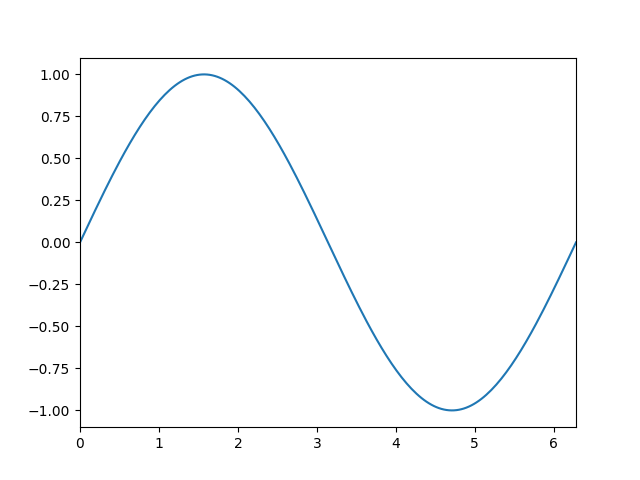

In [59]:
with Loom("sine_wave_animation.gif", fps=60, verbose=True) as loom:
    for phase in tqdm(np.linspace(0, 2*np.pi, 100)):
        fig, ax = plt.subplots()
        x = np.linspace(0, 2*np.pi, 200)
        y = np.sin(x + phase)
        
        ax.plot(x, y)
        ax.set_xlim(0, 2*np.pi)
        
        loom.save_frame(fig)

loom.show()

  0%|          | 0/36 [00:00<?, ?it/s]

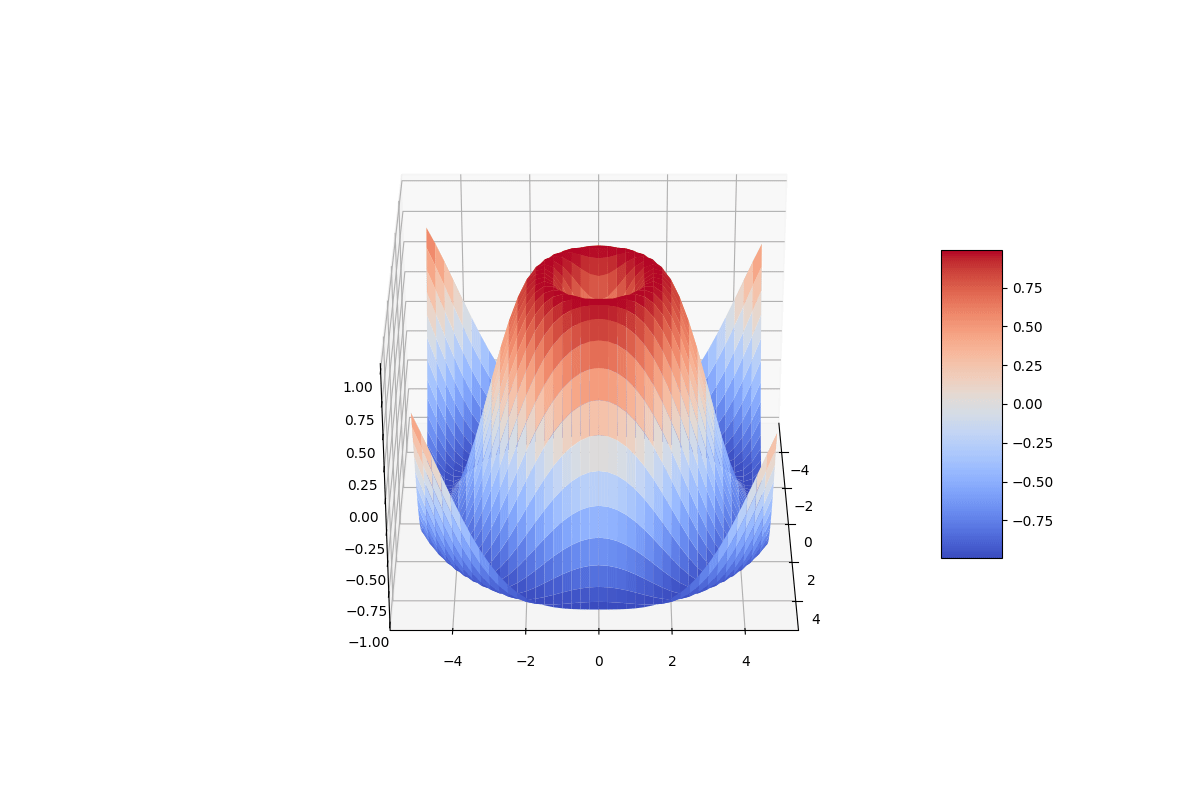

In [42]:
with Loom("3d_rotate.gif", fps=10) as loom:
    for i in tqdm(range(36)):
        fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={"projection": "3d"})
        
        X = np.arange(-5, 5, 0.25)
        Y = np.arange(-5, 5, 0.25)
        X, Y = np.meshgrid(X, Y)
        R = np.sqrt(X**2 + Y**2)
        Z = np.sin(R)
        
        surf = ax.plot_surface(X, Y, Z, cmap="coolwarm")
        
        ax.set_zlim(-1.01, 1.01)
        fig.colorbar(surf, shrink=0.5, aspect=5)
        
        ax.view_init(azim=i*10)

        loom.save_frame(fig)

loom.show()

In [5]:
Path("sine_wave_animation.mp4").suffix

'.mp4'